In [1]:
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns

Frequency Calculation

The following code takes as input the attribute list of all tables, along with all the transactions that have been classified as "not malicious". Its output is a table, with the first column containing time of execution of each transaction relative to the first transaction, and the remaining columns contain the frequencies of each attribute accessed corresponding to the transaction time.

In [2]:
def modify(transactions): #Returns the attributes accessed per transaction; removes read and write symbols
    
    modified = [] #New list of lists containing only attribute names in each transaction
    for tid in transactions:
        transaction = transactions[tid]
        current_modification = [] #List containing attributes for current transaction
        for operation in transaction:
            attribute = operation[2:-1] #Strip off R/W along with brackets
            current_modification.append(attribute)
        modified.append(current_modification)
    return modified

In [3]:
def frequencyDB(attributes, transactions_normal):
    
    time = [] #Times of all transactions
    time_transaction = 0 #Time of current transaction; initialised to 0 for 1st transaction
    attribute_frequencies = {} #Frequency of each attribute
    
    for at in attributes:
        attribute_frequencies[at] = [0 for i in range(len(transactions_normal))]
    
    modified_transactions = modify(transactions_normal) #Returns the attributes accessed per transaction, removing
                                                        #read and write symbols
    
    i = 0 #Represents the transaction number; used to modify lists in the dictionary
    for transaction in modified_transactions:
        time.append(time_transaction)
        for att in transaction:
            attribute_frequencies[att][i] = attribute_frequencies[att][i] + 1
        
        increment = randint(1, 10) #Generates a random time gap for the next transaction (1-10 minutes)
        time_transaction = time_transaction + increment
        i = i + 1 #Update the transaction number
        
    frequencies = pd.DataFrame(data=attribute_frequencies, index=time) #Return a table in the form of DataFrame
    return frequencies

In [4]:
#Test db taken
attr_list = ['T1_1', 'T1_2', 'T1_3', 'T1_4',
             'T2_1', 'T2_2', 'T2_3', 'T2_4', 'T2_5',
             'T3_1', 'T3_2', 'T3_3', 'T3_4']
transactions_normal = {'TID_1':['R(T1_2)', 'R(T2_3)', 'W(T1_2)', 'W(T1_2)'],
                      'TID_2':['W(T3_2)', 'R(T2_1)', 'R(T2_1)', 'R(T3_2)', 'W(T1_1)', 'R(T2_5)']}

In [5]:
frequencies = frequencyDB(attr_list, transactions_normal)
frequencies

,T1_1,T1_2,T1_3,T1_4,T2_1,T2_2,T2_3,T2_4,T2_5,T3_1,T3_2,T3_3,T3_4
0,1,0,0,0,2,0,0,0,1,0,2,0,0
7,0,3,0,0,0,0,1,0,0,0,0,0,0


Time Series Graph

The following code will take as input the frequencies database, and plot a line graph of frequency vs transaction time for each attribute in the database. It will also save the plot as an image file with the name "Time Graph.png"

In [6]:
def plotGraph(frequencies):
    
    fig = plt.figure()
    ax = fig.add_subplot(111) #Change the value to 121 when inserting legend (side by side)
    #ax_leg = fig.add_subplot(122)
    plt.tight_layout() #Doesn't let the 2 plots overlap
    attributes = frequencies.columns.values
    for at in attributes:
        ax.plot(frequencies[at]) #Plots a line graph on the same graph with time on x-axis and frequencies on y-axis
    plt.xlabel('Time (in minutes)')
    plt.ylabel('Frequencies')
    
    #ax_leg.legend(attributes, loc='center', ncol = int(frequencies.index[-1]/2)) #Yaha problem hai merko. Puri line hi change karni padegi
    plt.title('Time Series Analysis of Attributes')
    plt.savefig('Time Graph.png')
    plt.show()

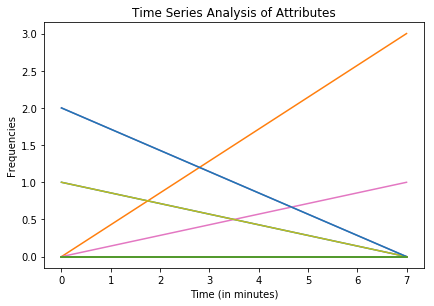

In [7]:
plotGraph(frequencies)

Anomaly Detection Module based on Frequency

The following code takes as input the frequencies database, the test query, and a relaxation factor
(default value=1), and returns whether the query is malicious (1) or not (0). It does so by finding the most similar normal query to the test query within the relaxation factor access bounds. If a similar query (s) is found at the end of the process, the query is allowed to execute, otherwise stopped.

In [5]:
def isMalicious(frequencies, test_transaction, relax_factor=1):
    
    for i in range(len(test_transaction)): #Only the attributes accessed remain
        test_transaction[i] = test_transaction[i][2:-1]
    
    test = np.unique(test_transaction, return_counts=True) #Return frequencies of accessed items in the test query
    similar_transactions = frequencies
                        #This database will contain similar transactions, which will be updated with each iteration
    for i in range(len(test[0])):
        current_attribute = test[0][i] #The test attribute to be checked
        test_frequency = test[1][i] #The corresponding frequency of the test attribute
        similar_transactions = similar_transactions[frequencies.current_attribute < test_frequency-relax_factor]
                            #Update the db to contain only those rows which satisfy the relaxation bounds for the
                            #current attribute
        if len(similar_queries) == 0:
            return 1 
                    #No similar query is found even after relaxation, therefore the query is flagged as malicious
    
    return 0 #Similar queries are present within relaxation bounds, therefore allow the transaction